# Generate Synthetic Data

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from typing import Tuple


def generate_scrolling_data(
    t, u, a=0.5, b=0.3, c=0.1, noise_std=0.05
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Generate synthetic data for a screen scrolling interaction.
    `t` and `u` are NumPy arrays representing time and input signal.
    """
    assert t is not None, "Time vector t must be provided"
    assert u.shape == t.shape, (
        "Input signal u must have the same shape as time vector t"
    )

    # Screen scroll dynamics in state space representation
    A = np.array([[0, 1], [-c / a, -b / a]])
    B = np.array([[0], [1 / a]])
    C = np.eye(2)
    D = np.zeros((2, 1))

    sys = signal.StateSpace(A, B, C, D)

    # Simulate the system and add some noise
    t_out, y_clean, x = signal.lsim(sys, u, t)
    noise = np.random.normal(0, noise_std, y_clean.shape)
    y_noisy = y_clean + noise

    return x, y_noisy, y_clean


def generate_input(t, u_max=1.0) -> np.ndarray:
    """
    Generate a simple input signal for the screen scrolling interaction.
    """
    u = np.zeros_like(t)

    # Randomly assign -1, 0, or 1 to the input signal
    i = 0
    while i < len(t) - 10:

        if np.random.rand() < 0.3:
            u[i:i+10] = np.random.choice([-1, 0, 1])
        
        if i > 20:
            u[i:i+10] = u[i-10:i]
        else:
            u[i:i+10] = 0

        i += 10

    # Add some random noise to inputs
    u += np.random.normal(0, 0.1, size=t.shape)

    # Clip the input signal to the range [-u_max, u_max]
    u = np.clip(u, -u_max, u_max)

    return u

In [48]:
np.random.seed(42)
N = 300
ts = np.linspace(0, N, N + 1)
us = generate_input(ts)
xs, ys, y_clean = generate_scrolling_data(ts, us)

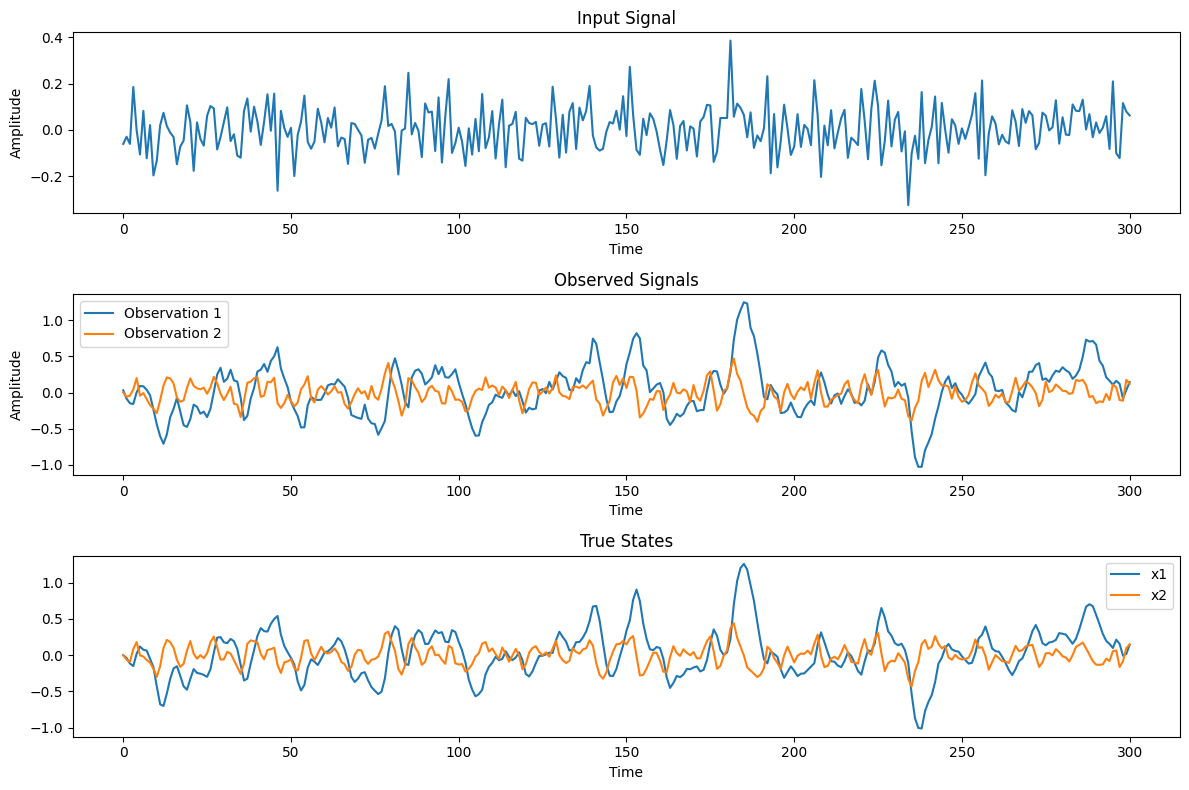

In [49]:
def plot_signals(
    ts: np.ndarray, us: np.ndarray, ys: np.ndarray, xs: np.ndarray
) -> None:
    """Plot the datasets"""
    fig = plt.figure(figsize=(12, 8))

    # Plot input signals
    plt.subplot(3, 1, 1)
    plt.plot(ts, us)
    plt.title("Input Signal")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")

    # Plot output signals
    seq_len, obs_dim = ys.shape
    assert obs_dim == 2, "Output signal must have 2 dimensions"
    plt.subplot(3, 1, 2)
    for i in range(obs_dim):
        plt.plot(ts, ys[:, i], label=f"Observation {i + 1}")
    plt.title("Observed Signals")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend()

    # Plot true states
    seq_len, state_dim = xs.shape
    plt.subplot(3, 1, 3)
    for i in range(state_dim):
        plt.plot(ts, xs[:,i], label=f"State {i + 1}")
    plt.title("True States")
    plt.legend(["x1", "x2"])
    plt.xlabel("Time")

    plt.tight_layout()

    # Show all figures
    plt.show()


plot_signals(ts, us, ys, xs)

# Model and Inference

In [50]:
import arviz as az
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import numpyro.distributions.constraints as constraints
import os
import pandas as pd
import seaborn as sns
from jax import lax, random
from numpyro.contrib.control_flow import scan
from numpyro.diagnostics import hpdi
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.infer.util import initialize_model
from numpyro.primitives import plate

numpyro.set_platform("cpu")
numpyro.set_host_device_count(1)

In [51]:
def lgssm(U, X, Y):
    num_time_steps, input_dim = U.shape
    num_input_time_steps, state_dim = X.shape
    num_obs_time_steps, obs_dim = Y.shape
    assert num_time_steps == num_input_time_steps, "Time steps must match"
    assert num_time_steps == num_obs_time_steps, "Time steps must match"

    # Parameters for the state space model
    a = numpyro.sample("a", dist.Gamma(1.0, 1.0,))
    b = numpyro.sample("b", dist.Gamma(1.0, 1.0,))
    c = numpyro.sample("c", dist.Gamma(1.0, 1.0,))

    A = jnp.array([[0, 1], [-c / a, -b / a]])
    B = jnp.array([[0], [1 / a]])
    C = jnp.eye(2)

    # For each state, set the initial state and define noise
    with plate("state_dim", state_dim):        
        x0 = numpyro.sample("x0", dist.Normal(0, 1))
        qs = numpyro.sample("Q", dist.HalfNormal(1.0))
    
    with plate("obs_dim", obs_dim):
        rs = numpyro.sample("R", dist.HalfNormal(1.0))
    
    Q = jnp.diag(qs)
    R = jnp.diag(rs)
    
    # Define the transition function for scanning
    def transition_fn(x_prev, t):
        x = jnp.dot(A, x_prev) + jnp.dot(B, U[t])
        x_t = numpyro.sample(f"x_{t}", dist.MultivariateNormal(x, Q))

        y = jnp.dot(C, x_t)
        numpyro.sample(f"y_{t}", dist.MultivariateNormal(y, R), obs=Y[t])
        return x_t, None

    _, _ = scan(transition_fn, x0, jnp.arange(1, num_time_steps))

    return


# Format the data
U = jnp.array(us).reshape((-1, 1))
X = jnp.array(xs)
Y = jnp.array(ys)

print(U.shape)
print(X.shape)
print(Y.shape)

with numpyro.handlers.seed(rng_seed=0):
    lgssm(U, X, Y)

(301, 1)
(301, 2)
(301, 2)


In [ ]:
rng_key = random.PRNGKey(0)
kernel = NUTS(lgssm)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=1)
mcmc.run(rng_key=rng_key, U=U, X=X, Y=Y)
mcmc.print_summary()

warmup:   9%|▉         | 180/2000 [00:09<00:45, 39.98it/s, 15 steps of size 1.39e-01. acc. prob=0.78] 

In [ ]:
samples = mcmc.get_samples()
a_mean = jnp.mean(samples["a"])
b_mean = jnp.mean(samples["b"])
c_mean = jnp.mean(samples["c"])

a_true = 0.5
b_true = 0.3
c_true = 0.1

print(f"a = {a_mean:.2f} (true: {a_true})")
print(f"b = {b_mean:.2f} (true: {b_true})")
print(f"c = {c_mean:.2f} (true: {c_true})")

A_estimate = jnp.array([[0, 1], [-c_mean / a_mean, -b_mean / a_mean]])
B_estimate = jnp.array([[0], [1 / a_mean]])

print("-" * 10)
print(f"A = \n{A_estimate}")
print(f"True A = \n{np.array([[0, 1], [-c_true / a_true, -b_true / a_true]])}")

print("-" * 10)
print(f"B = \n{B_estimate}")
print(f"True B = \n{np.array([[0], [1 / a_true]])}")


a = 2.85 (true: 0.5)
b = 0.05 (true: 0.3)
c = 0.16 (true: 0.1)
----------
A = 
[[ 0.          1.        ]
 [-0.05495026 -0.0162402 ]]
True A = 
[[ 0.   1. ]
 [-0.2 -0.6]]
----------
B = 
[[0.        ]
 [0.35085455]]
True B = 
[[0.]
 [2.]]


# Visualization

## Parameter Estimation

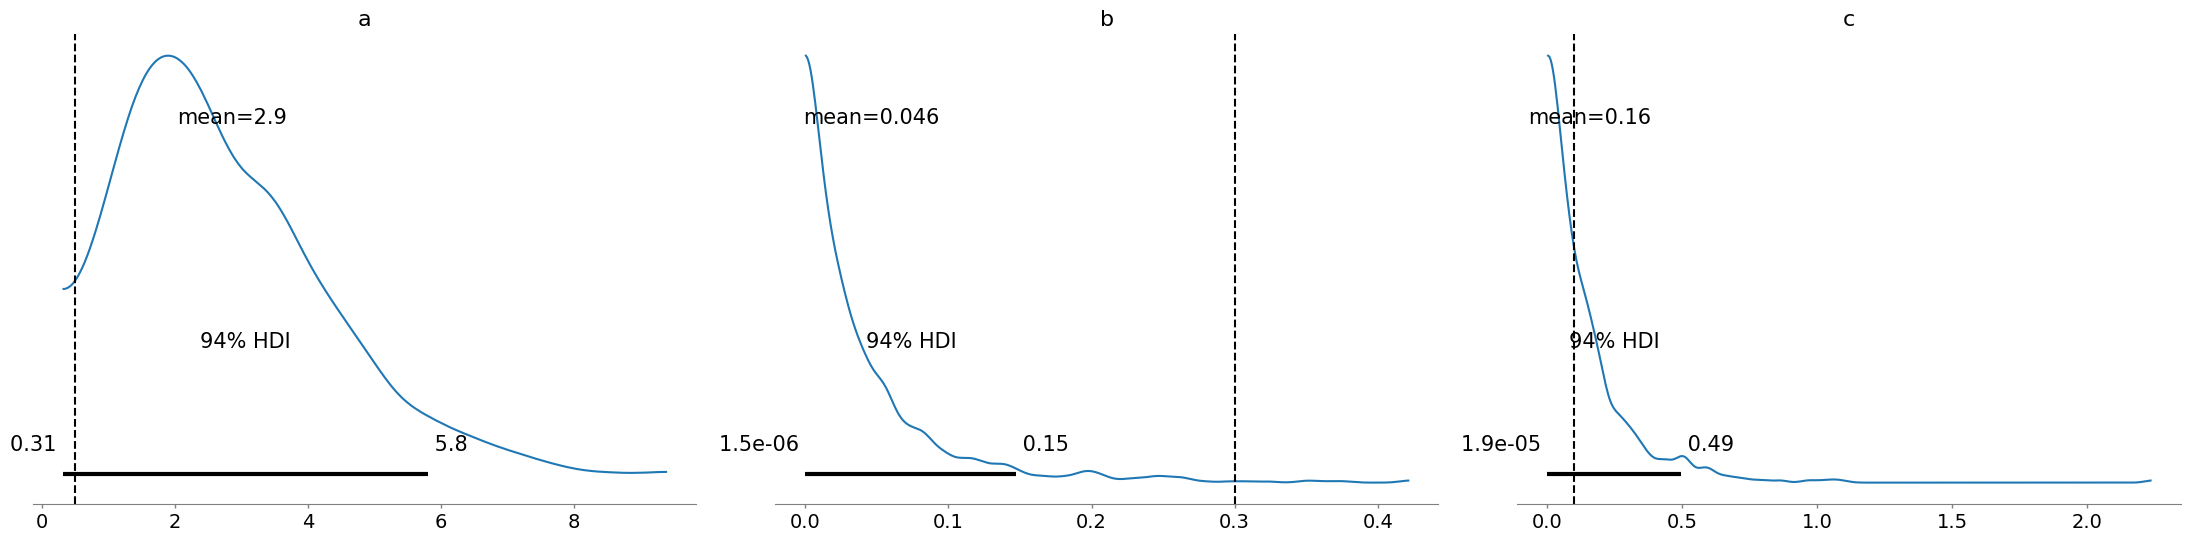

In [42]:
# Convert to arviz for nice plots
az_data = az.from_numpyro(mcmc)
axes = az.plot_posterior(az_data, var_names=["a", "b", "c"])
axes[0].axvline(a_true, color="k", linestyle="--")
axes[1].axvline(b_true, color="k", linestyle="--")
axes[2].axvline(c_true, color="k", linestyle="--")
plt.tight_layout()
plt.show()

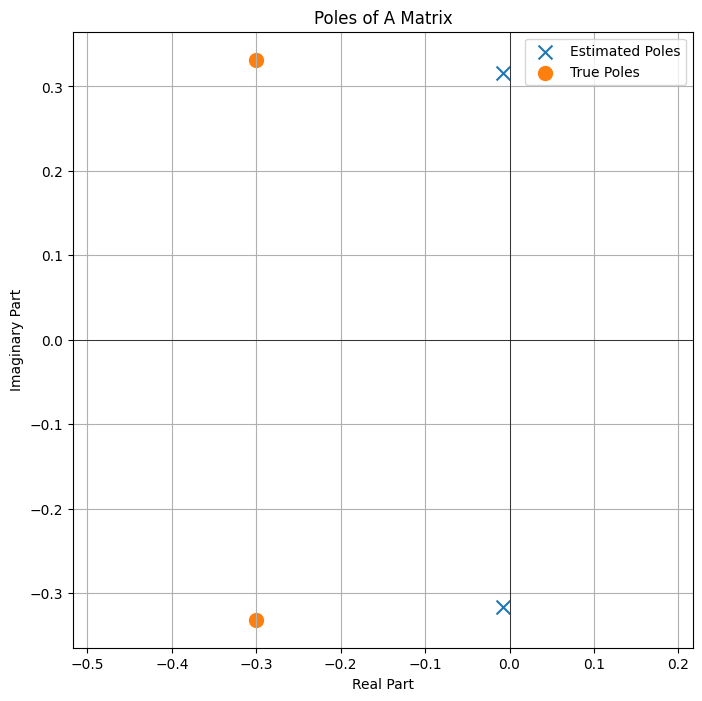

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Estimated A matrix
a_est = 1.30
b_est = 0.02
c_est = 0.13
A_est = np.array([[0, 1], [-c_est / a_est, -b_est / a_est]])

# True A matrix
a_true = 0.5
b_true = 0.3
c_true = 0.1
A_true = np.array([[0, 1], [-c_true / a_true, -b_true / a_true]])

# Calculate eigenvalues (poles)
poles_est = np.linalg.eigvals(A_est)
poles_true = np.linalg.eigvals(A_true)

# Plot the poles
plt.figure(figsize=(8, 8))

# Plot estimated poles
plt.scatter(poles_est.real, poles_est.imag, marker='x', s=100, label='Estimated Poles')

# Plot true poles
plt.scatter(poles_true.real, poles_true.imag, marker='o', s=100, label='True Poles')

# Add unit circle
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
plt.gca().add_artist(circle)

# Add axes lines
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

# Set axis limits and labels
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.title('Poles of A Matrix')
plt.legend()
plt.grid(True)
plt.axis('equal')  # Ensure equal scaling of axes
plt.show()

## State Estimation

In [44]:
x_samples = samples['x_Traced<ShapedArray(int32[])>with<DynamicJaxprTrace>']
num_samples, num_time_steps_minus_1, state_dim = x_samples.shape
x_posterior_samples = {}
for t in range(num_time_steps_minus_1):
    x_posterior_samples[f"x_{t + 1}"] = x_samples[:, t, :]

In [45]:
def credible_interval(samples, alpha=0.95):
    lower_percentile = (1 - alpha) / 2 * 100
    upper_percentile = (1 + alpha) / 2 * 100
    lower = np.percentile(samples, lower_percentile, axis=0)
    upper = np.percentile(samples, upper_percentile, axis=0)
    mean = np.mean(samples, axis=0)
    return lower, upper, mean

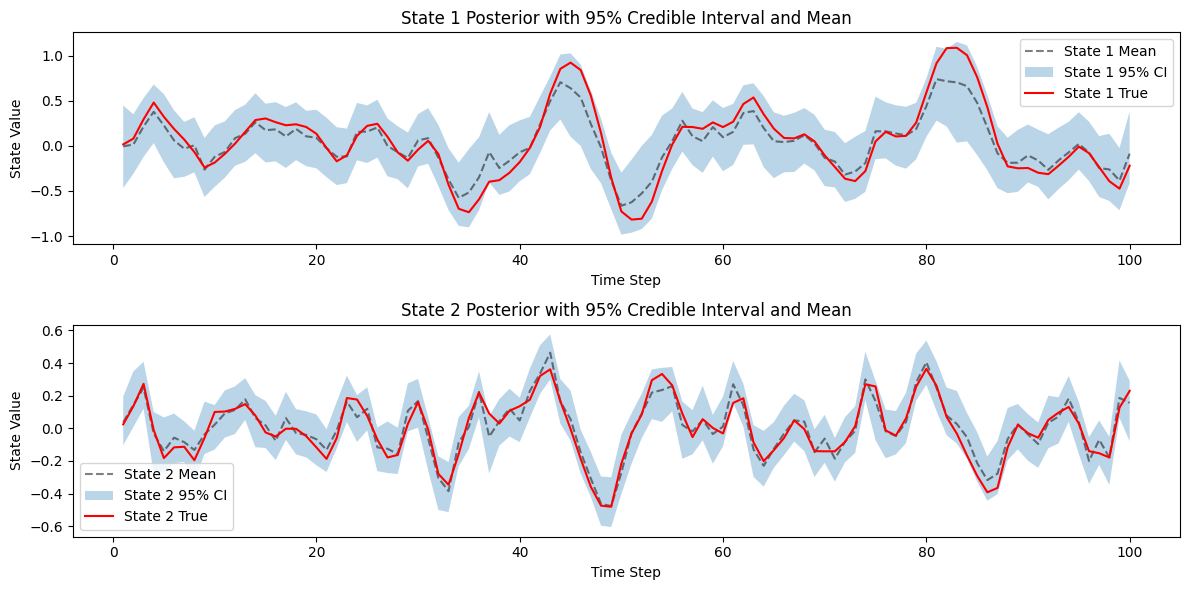

In [46]:
def credible_interval(samples, alpha=0.95):
    lower_percentile = (1 - alpha) / 2 * 100
    upper_percentile = (1 + alpha) / 2 * 100
    lower = np.percentile(samples, lower_percentile, axis=0)
    upper = np.percentile(samples, upper_percentile, axis=0)
    mean = np.mean(samples, axis=0)
    return lower, upper, mean


time_steps = range(1, num_time_steps_minus_1 + 1)

plt.figure(figsize=(12, 6))

for state_idx in range(state_dim):
    lower_bounds = []
    upper_bounds = []
    mean_values = []

    for t in time_steps:
        samples = x_posterior_samples[f"x_{t}"][:, state_idx]
        lower, upper, mean = credible_interval(samples)
        lower_bounds.append(lower)
        upper_bounds.append(upper)
        mean_values.append(mean)

    plt.subplot(2, 1, state_idx + 1)
    plt.plot(
        time_steps,
        mean_values,
        label=f"State {state_idx + 1} Mean",
        color="black",
        alpha=0.5,
        linestyle="--",
    )
    plt.fill_between(
        time_steps,
        lower_bounds,
        upper_bounds,
        alpha=0.3,
        label=f"State {state_idx + 1} 95% CI",
    )

    plt.plot(
        time_steps,
        X[1:, state_idx],
        label=f"State {state_idx + 1} True",
        color="red",
        alpha=1)

    plt.xlabel("Time Step")
    plt.ylabel("State Value")
    plt.title(f"State {state_idx + 1} Posterior with 95% Credible Interval and Mean")
    plt.legend()

plt.tight_layout()
plt.show()